# <font color='Teal'> **ТЕМА 3. КОГНИТИВНЫЕ ПОДХОДЫ, СИСТЕМЫ И СЕРВИСЫ В ЦИФРОВОМ БИЗНЕСЕ**

В современном цифровом бизнесе когнитивные подходы играют ключевую роль, обеспечивая возможности для глубокого анализа и автоматизации решений на основе машинного обучения и искусственного интеллекта. Когнитивные системы способны обрабатывать и интерпретировать огромные объемы данных, имитируя человеческое мышление и восприятие. Это включает в себя обработку естественного языка, компьютерное зрение и автоматическое принятие решений, что позволяет компаниям улучшать взаимодействие с клиентами, оптимизировать операции и, конечно же, повышать конкурентоспособность.

Построенные на когнитивных технологиях сервисы способны анализировать поведение пользователей, предсказывать тенденции и предлагать персонализированные решения. Такие системы могут применяться в самых разных сферах, от электронной коммерции до здравоохранения и финансов, где помогают создавать новые уровни взаимодействия с клиентами и управления данными.

##<font color='Teal'> **ЛАБОРАТОРНАЯ РАБОТА 3**

В рамках данной лабораторной работы рассматривается практическое применение когнитивных подходов (в данном случае методов машинного зрения) на примере анализа и обработки изображений с помощью предобученной нейронной сети VGG16. Будет показано, как можно извлечь признаки из изображений, проанализировать их сходство и затем использовать полученные данные для улучшения пользовательского опыта и эффективности рекомендательных систем.

###<font size=6 color='Teal'> Подготовка среды и данных

Импортируем необходимые для выполнения лабораторной работы библиотеки.

In [1]:
import os

from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import plotly.express as px
import plotly.graph_objects as go
from keras.applications import vgg16
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity

Подключаем Google Drive к окружению Google Colab, что позволит получить доступ к файлам, хранящимся в Google Drive, непосредственно из среды выполнения Colab.

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
home = '/content/drive/MyDrive/Предиктивная аналитика/lab2'
imgs_path = f"{home}/fashion-dataset.zip"

In [4]:
import zipfile
import os

# Путь к zip-файлу и целевой директории
zip_file_path = f"{home}/fashion-dataset.zip"
extract_dir = 'fashion-dataset'

# Распаковка zip-файла
with zipfile.ZipFile(imgs_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Файлы распакованы в директорию {extract_dir}.")


Файлы распакованы в директорию fashion-dataset.


Определим путь к директории с изображениями, затем проверим наличие файлов в указанной директории.

In [5]:
imgs_path = f'{extract_dir}/images'
imgs_model_width, imgs_model_height = 224, 224

In [6]:
try:
    files_and_dirs = os.listdir(imgs_path)
    if files_and_dirs:
        print("Директория не пуста")
    else:
        print("Директория пуста.")
except FileNotFoundError:
    print(f"Директория {imgs_path} не найдена.")
except PermissionError:
    print(f"Нет разрешения на доступ к директории {imgs_path}.")

Директория не пуста


Создадим список файлов в указанной директории, содержащий только файлы с расширением `jpg`.

In [7]:
files = [f'{imgs_path}/{x}' for x in os.listdir(imgs_path) if "jpg" in x]
print("Total number of images:", len(files))

Total number of images: 44441


In [8]:
files[:5]

['fashion-dataset/images/45345.jpg',
 'fashion-dataset/images/19224.jpg',
 'fashion-dataset/images/29040.jpg',
 'fashion-dataset/images/22336.jpg',
 'fashion-dataset/images/26256.jpg']

###<font size=6 color='Teal'> Исследование данных (EDA) и визуализация

Считываем данные из CSV-файла (`styles.csv`) и выводим первые строки для обзора структуры и содержания данных.

In [9]:
styles = pd.read_csv(f"{extract_dir}/styles.csv", on_bad_lines='skip')

In [10]:
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


Построим круговую диаграмму, отображающую долю товаров, предназначенных для мужчин и женщин.

In [11]:
fig = px.pie(styles, styles['gender'], color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title="Распределение товаров", width=800, height=800, font=dict(family="Segoe UI semilight", size=16))
fig.show()

Вычислим количество товаров в каждой главной категории и построим столбчатую диаграмму, чтобы показать, какие категории товаров наиболее популярны.

In [12]:
catcounts = pd.value_counts(styles['masterCategory'])

In [13]:
fig = go.Figure([go.Bar(x=catcounts.index, y=catcounts.values, text=catcounts.values, marker_color='darkkhaki')])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title="Топ категории", width=1000, height=900, xaxis_title='Категория',
                  yaxis_title='Количество покупок', font=dict(family="Segoe UI semilight", size=16))
fig.show()

Как видно из диагарммы большей популярностью пользуется одежда.

Теперь построим диаграмму разброса, показывающую зависимость количества покупок от времени года, чтобы выявить, в какие сезоны происходит больше всего покупок.

In [14]:
seasons = pd.value_counts(styles['season'])

In [15]:
fig = go.Figure(data=[go.Scatter(x=seasons.index, y=seasons.values, mode='markers',
    marker=dict(color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)', 'rgb(44, 160, 101)', 'rgb(255, 65, 54)'],
                opacity=[0.6, 0.7, 0.8, 1], size=[123, 65, 49, 17]))])
fig.update_layout(width=900, height=900, title="Зависимость количества покупок от времени года", xaxis_title='Сезон', yaxis_title='Количество',
                  font=dict(family="Segoe UI semilight", size=16))
fig.show()

Видно, что 3/4 товаров покупаются летом и осенью.

Вычислим количество товаров по типам и построим столбчатую диаграмму для отображения топ-15 самых популярных типов товаров.

In [16]:
articles = pd.value_counts(styles['articleType'])
fig = go.Figure(
    [
        go.Bar(
            x=articles.index[:15],
            y=articles.values[:15],
            text=articles.values[:15],
            marker_color='darkmagenta'
            )
        ]
    )
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(
    title="Топ 15 категорий",
    xaxis_title='Категория',
    yaxis_title='Количество покупок',
    width=950,
    height=750,
    font=dict(family="Segoe UI semilight", size=16)
    )
fig.show()

Футболки и рубашки — лидеры продаж. Очевидно, это наиболее подходящая одежда для лета и осени в регионе.

###<font size=6 color='Teal'> Модель VGG16

Модель VGG16 — это сверточная нейронная сеть, разработанная командой Visual Geometry Group из Оксфордского университета, которая состоит из 16 слоев с обучаемыми весами, включая 13 сверточных и 3 полносвязных слоя, использующих маленькие фильтры 3x3 для захвата пространственных характеристик изображений. Обученная на большом наборе данных ImageNet, VGG16 способна с высокой точностью классифицировать изображения и широко используется для задач компьютерного зрения, таких как классификация, детектирование объектов и сегментация. Благодаря своей глубине и простоте архитектуры, VGG16 эффективно извлекает сложные признаки из изображений, но требует значительных вычислительных ресурсов.

Извлечение признаков из одного изображения необходимо для проверки корректности процесса загрузки, предобработки и извлечения признаков с использованием модели VGG16, что позволяет убедиться в работоспособности метода, лучше понять структуру данных и интерпретацию модели, оптимизировать и отладить код, а также подготовить основу для дальнейшей масштабной обработки большого набора изображений.

Чтобы уменьшить время выполнения алгоритма и предотвратить остановку ядра, количество обрабатываемых изображений сокращается до 4000.

In [17]:
files=files[0:2001]

Загружаем одно из изображений (433-е по счёту) с помощью функции `load_img()`, которое затем отображается с использованием `plt.imshow()`. Это продемонстирует пример данных, с которыми будет работать модель.

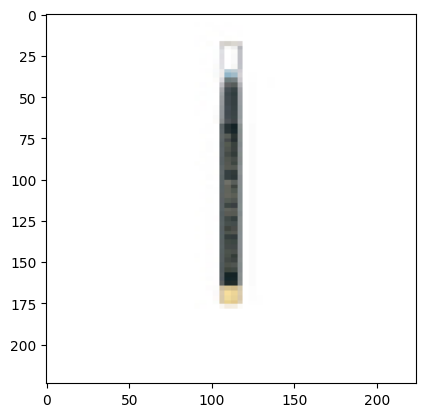

Пример данных


In [18]:
original = load_img(files[433], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("Пример данных")

На вход сети будут подаваться трехканальные изображения 224х224.

Загрузим предобученную на ImageNet модель VGG16. Поскольку задача заключается в извлечении признаков, последние слои, отвечающие за классификацию, удаляются, и создаётся новая модель `feat_extractor`, которая выводит признаки из предпоследнего слоя `fc2`.

In [19]:
vgg_model = vgg16.VGG16(weights='imagenet');
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output);
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Эти данные описывают архитектуру предобученной модели VGG16, которая была загружена с весами, тренированными на наборе данных ImageNet. Модель состоит из нескольких слоев, включая свёрточные (Conv2D) и пулинговые (MaxPooling2D) слои, расположенные в блоках, а также полносвязные слои (Dense) на выходе. Всего модель содержит 134 260 544 параметра (около 512,16 МБ), все из которых являются обучаемыми. Вывод Output Shape указывает на форму данных, проходящих через каждый слой, начиная с входного слоя размером 224x224x3 (RGB изображение) и заканчивая последними полносвязными слоями, которые формируют вектор признаков длиной 4096. Весь этот процесс позволяет модели извлекать сложные и абстрактные признаки из входных изображений.

Исходное изображение преобразуем в массив с помощью `img_to_array()`, а затем добавляем дополнительное измерение для соответствия форме входных данных модели (`batchsize`,`height`, `width`, `channels`). Затем изображение подготавливаем для модели VGG16 с использованием функции `preprocess_input()`, которая преобразует цвета из RGB в BGR и центрирует их по отношению к набору данных ImageNet.

In [20]:
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis=0)
print('Размерность входных данных', image_batch.shape)

processed_image = preprocess_input(image_batch.copy())

Размерность входных данных (1, 224, 224, 3)


Из подготовленного изображения извлекаем признаки с помощью модели `feat_extractor` и выводим количество извлечённых признаков.

In [21]:
img_features = feat_extractor.predict(processed_image)
print("Извлечены признаки одного изображения")
print("Количество признаков:", img_features.size)

1/1 [==============================] - 3s 3s/step
Извлечены признаки одного изображения
Количество признаков: 4096


Таким образом, на этом этапе загружается одно изображение, подготавливается предобученная модель VGG16 для извлечения признаков, и извлекаются признаки из изображения для дальнейшего анализа.

Теперь извлечем признаки из множества изображений с помощью модели VGG16, вычислим матрицу косинусного подобия между изображениями, и на основе этой матрицы создадим функцию, которая найдет и отобразит наиболее релевантные товары для заданного изображения, показывая четыре самых похожих товара с указанием степени их сходства.

Последовательно загружаем изображения из списка `files`, преобразуем их в массивы, добавляем измерение для соответствия форме входных данных модели, и сохраняем их в список `importedImages`. Все изображения объединим в один массив `images`, который затем предобработаем с помощью функции `preprocess_input`. После этого извлечем признаки из всех изображений с использованием модели `feat_extractor`.

In [22]:
importedImages = []
for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    importedImages.append(image_batch)
images = np.vstack(importedImages)
processed_imgs = preprocess_input(images.copy())

In [23]:
imgs_features = feat_extractor.predict(processed_imgs)
print("Признаки извлечены")
imgs_features.shape

63/63 [==============================] - 16s 169ms/step
Признаки извлечены


(2001, 4096)

In [25]:
print("Извлечено", imgs_features.shape[1], "признаков для каждого из", imgs_features.shape[0], "изображений.")

Извлечено 4096 признаков для каждого из 2001 изображений.


Вычислим матрицу косинусного подобия между признаками изображений с помощью функции `cosine_similarity`. Полученную матрицу сходства загрузим в датафрейм `cos_similarities_df`, где строки и столбцы будут соответствовать файлам изображений.

Матрица косинусного подобия используется для количественной оценки схожести между всеми парами изображений в наборе данных; она измеряет угол между векторами признаков, позволяя ранжировать и находить наиболее похожие изображения. Это важно для создания системы рекомендаций, где для любого заданного изображения можно быстро определить и предложить несколько наиболее схожих товаров, что особенно полезно в приложениях электронной коммерции.

In [26]:
cosSimilarities = cosine_similarity(imgs_features)
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,fashion-dataset/images/45345.jpg,fashion-dataset/images/19224.jpg,fashion-dataset/images/29040.jpg,fashion-dataset/images/22336.jpg,fashion-dataset/images/26256.jpg,fashion-dataset/images/26224.jpg,fashion-dataset/images/9698.jpg,fashion-dataset/images/19869.jpg,fashion-dataset/images/7140.jpg,fashion-dataset/images/55520.jpg,...,fashion-dataset/images/51446.jpg,fashion-dataset/images/39936.jpg,fashion-dataset/images/27322.jpg,fashion-dataset/images/55570.jpg,fashion-dataset/images/5290.jpg,fashion-dataset/images/57779.jpg,fashion-dataset/images/41602.jpg,fashion-dataset/images/38449.jpg,fashion-dataset/images/15717.jpg,fashion-dataset/images/4641.jpg
fashion-dataset/images/45345.jpg,1.000000,0.485992,0.348911,0.408294,0.385318,0.382925,0.376297,0.349404,0.433186,0.419374,...,0.393538,0.439584,0.347619,0.424134,0.514913,0.390645,0.456755,0.599729,0.388645,0.512843
fashion-dataset/images/19224.jpg,0.485992,1.000000,0.476326,0.484370,0.523415,0.540908,0.255660,0.250934,0.518872,0.563418,...,0.440090,0.445395,0.485596,0.497461,0.374853,0.406491,0.492797,0.609566,0.206303,0.320175
fashion-dataset/images/29040.jpg,0.348911,0.476326,1.000000,0.559499,0.459750,0.372429,0.229391,0.297720,0.646714,0.523030,...,0.537513,0.403629,0.529954,0.475166,0.274216,0.521022,0.585511,0.450521,0.271560,0.317488
fashion-dataset/images/22336.jpg,0.408294,0.484370,0.559499,1.000000,0.486763,0.437641,0.256903,0.227627,0.704763,0.500346,...,0.636381,0.372086,0.448612,0.398156,0.360609,0.324459,0.618479,0.460673,0.204432,0.324065
fashion-dataset/images/26256.jpg,0.385318,0.523415,0.459750,0.486763,1.000000,0.423132,0.271183,0.228174,0.523786,0.458705,...,0.583168,0.334687,0.349764,0.400882,0.302759,0.332708,0.518952,0.433817,0.218439,0.280914


Определим функцию `retrieve_relevant_products()`, которая будет находить и отображать четыре наиболее релевантных товара для заданного изображения на основе косинусного подобия. Функция отобразит исходное изображение и четыре наиболее похожих изображения, вместе с процентным значением их схожести.

In [27]:
nb_closest_images = 4

def retrieve_relevant_products(given_img):
    print("     Выбранный товар")
    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()
    print("    _____________________________")
    print("    Релевантные товары")
    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = 100*cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]
    for i in range(0, len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("     Схожесть: ", round(closest_imgs_scores[i], 2), "%")

     Выбранный товар


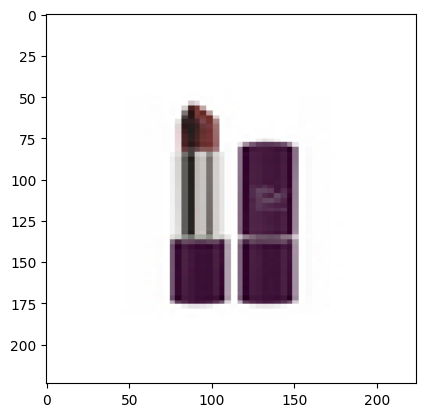

    _____________________________
    Релевантные товары


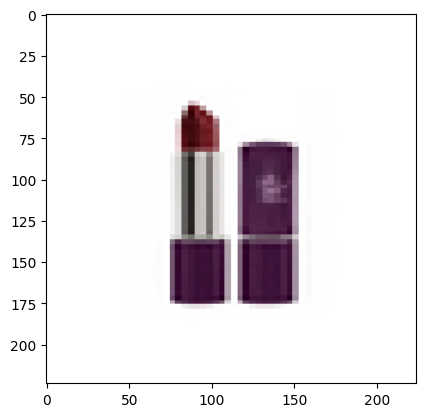

     Схожесть:  98.81 %


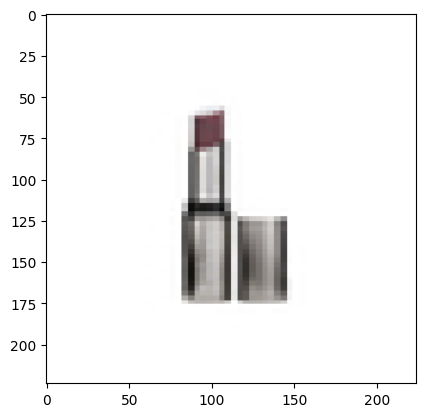

     Схожесть:  92.15 %


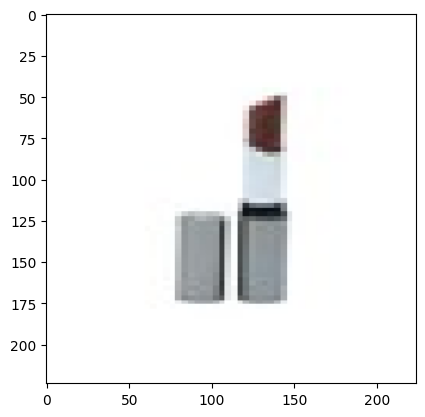

     Схожесть:  91.99 %


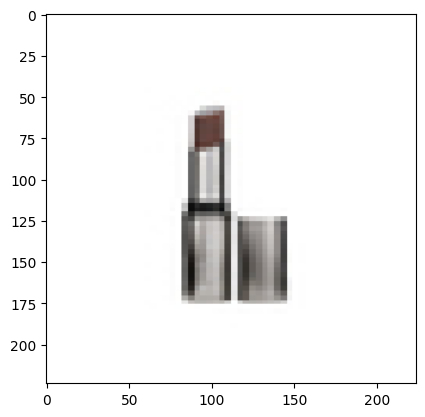

     Схожесть:  90.69 %


In [28]:
retrieve_relevant_products(files[651])

     Выбранный товар


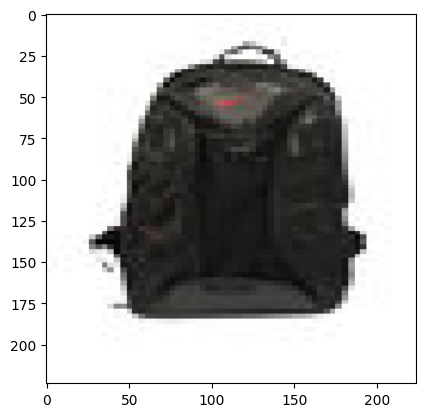

    _____________________________
    Релевантные товары


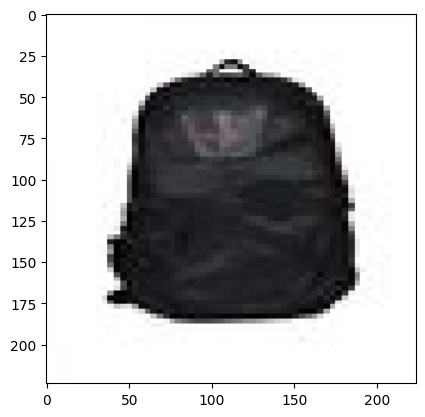

     Схожесть:  79.0 %


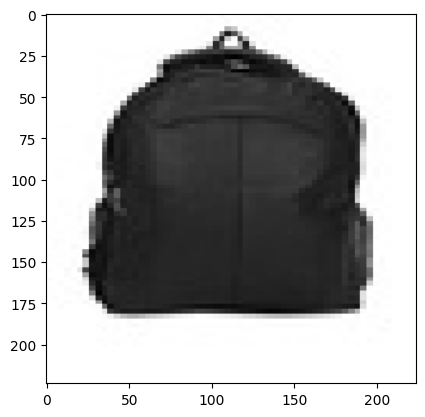

     Схожесть:  73.64 %


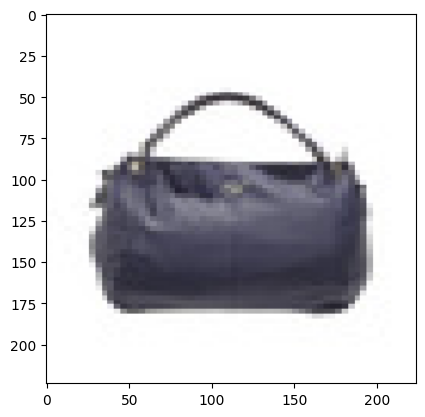

     Схожесть:  73.21 %


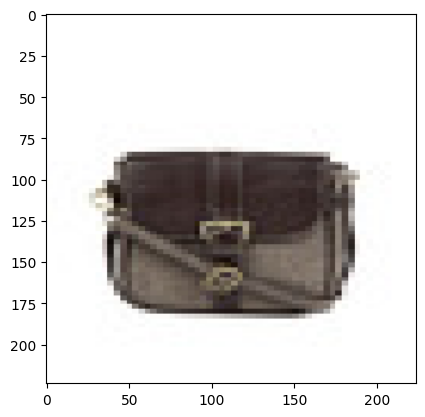

     Схожесть:  73.11 %


In [29]:
retrieve_relevant_products(files[792])

На основе проведённого анализа можно сделать несколько выводов.

Во-первых, рекомендации товаров, показанных на моделях, оказываются более точными, так как присутствие модели помогает алгоритму лучше распознавать и классифицировать предметы одежды, что особенно важно для определения таких характеристик, как пол. Это может улучшить релевантность предложений и повысить удовлетворённость пользователей.

Во-вторых, существует потенциальная проблема: если разные модели внешне схожи, система может ошибочно считать товары похожими из-за сходства моделей, а не самих предметов одежды. Это может привести к рекомендациям, которые не соответствуют реальным предпочтениям пользователей или характеристикам товаров. Таким образом, для повышения точности рекомендаций необходимо учитывать не только внешность моделей, но и специфические особенности самих товаров.

##<font color='Teal'> **ЗАДАНИЕ**

**Цель:** Разработка алгоритма создания рекомендательного онлайн-сервиса и оценка качества его рекомендаций.

**Задания:**

1. **Изучение архитектуры и работы сверточных нейронных сетей (CNN):**
   - Ознакомьтесь с архитектурой и работой сверточных нейронных сетей, используя фреймворк PyTorch. Для этого используйте файл [CNN_convnet_pytorch.ipynb](https://colab.research.google.com/drive/1eUUsQIVd9AKl9Do_MySouyLFqrCoNWoM).
   - Проанализируйте основные компоненты и слои CNN: свёрточные слои, пулинговые слои и полносвязные слои, а также их роль в обработке и классификации изображений.

2. **Классификация изображений с использованием CNN:**
   - Решите задачи классификации изображений на наборах данных MNIST и CIFAR с использованием сверточных нейронных сетей.
   - Проведите серию экспериментов, изменяя гиперпараметры модели (например, количество слоев, размер фильтров, скорость обучения и т.д.) для улучшения качества классификации.
   - Документируйте и проанализируйте полученные результаты, сравнив их с базовыми показателями.

3. **Изучение технологии transfer learning:**
   - Ознакомьтесь с технологией transfer learning (переносное обучение) на примере файла [transfer_learning.ipynb](https://colab.research.google.com/drive/1zN55rxZOhpxd4wNovo6lkzAQN3humaa2).
   - Исследуйте, как предварительно обученные модели могут быть адаптированы для решения новых задач с меньшим количеством данных.

4. **Классификация изображений с использованием transfer learning:**
   - Используйте технологию transfer learning для решения задачи классификации изображений (муравьи и пчелы).
   - Проведите эксперименты с различными настройками нейросети и архитектурами предварительно обученных моделей для улучшения результатов.
   - Оцените эффективность transfer learning по сравнению с обучением модели с нуля.

5. **Разработка рекомендательной системы на основе схожести товаров:**
   - Постройте рекомендательную систему, используя данные [Kaggle Fashion Product Images Dataset](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset) (см. лабораторную работу 3).
   - Ограничьтесь выборкой из 10000 товаров из предоставленного набора данных.
   - Разработайте алгоритм, который на основе извлеченных признаков изображений будет рекомендовать пользователям схожие товары.
   - Продумайте и реализуйте возможные улучшения системы: оптимизация алгоритма, улучшение качества извлеченных признаков или использование дополнительных данных.

**Требования к отчету:**
- Подробное описание всех проведенных экспериментов и их результатов.
- Анализ эффективности различных подходов и архитектур нейронных сетей.
- Обоснование выбранных гиперпараметров и стратегий улучшения моделей.
- Выводы и рекомендации по дальнейшему улучшению разработанных систем.